# Hadoop 구축

## 1. 실행 모드 결정

|실행 모드|용도|
|---|---|
|독립 실행(Standalone)모드|- Hadoop의 기본 실행 모드<br> - Hadoop환경설정 파일에 아무런 설정을 하지 않고 실행하면 로컬 장비에서만 실행되기 때문에 local모드라고 함<br> - Hadoop에서 제공하는 데몬을 구동하지 않기 때문에 분산 환경을 고려한 테스트 불가능 <br> - 단순히 MapReduce 프로그램을 개발하고, 해당 MapReduce를 디버깅하는 용도로 활용 |
|가상 분산(Pseudo-distributed)모드|- 하나의 머신에 모든 Hadoop환경설정을 하고, Hadoop서비스도 이 머신에서만 제공하는 방식 <br> - HDFS와 MapReduce관련 데몬을 하나의 장비에서만 실행 <br> - 주로 Hadoop을 처음 학습하는 경우 이 같은 방식으로 테스트 환경 구성|
|완전 분산(Fully distributed)모드|- 여러 대의 머신에 Hadoop을 설치하는 경우<br> - Hadoop을 라이브 서비스 하게 되는 경우 이와 같은 방식으로 구성|


## 2. 서버 준비

* Hadoop은 Linux 및 다양한 Unix계열 운영체제에서 설치 가능
* 가상머신 4대 운용

|호스트명|설치내용|Processors|Memory|Storage|OS|
|---|---|---|---|---|---|
|master|HDFS NameNode YARN <br> ResourceManager <br> WebAppProxyServer <br> MapReduce Job History <br> Server|2|4GB|20GB|Ubuntu|
|worker01|HDFS SecondaryNameNode <br> DataNode YARN <br> NodeManager|2|4GB|20GB|Ubuntu|
|worker02|HDFS DataNode YARN <br> NodeManger|2|2GB|20GB|Ubuntu|
|worker03|HDFS DataNode YARN <br> NodeManger|2|2GB|20GB|Ubuntu|


* 보통 SecondaryNameNode(보조 네임 노드)는 NameNode가 설치되는 서버와 동일한 사양의 서버에 설치하며, DataNode같은 데몬을 같이 설치하지 않음
* SecondaryNames는 NameNode에 장애 발생에 대비하는 용도로, NameNode와 같은 사양으로 별도 서버에 설치 필요
* 실습에선 worker01과 같이 SecondaryNameNode와 DataNode를 하나의 머신에 설치하지만 실사용시엔 SecondaryNameNode만 단독 설치 권장

* 서비스용으로 Hadoop 구축 시에는 더 다양한 요소 고려 필요
* 디스크 I/O의 발생 빈도
* MapReduce 분석 작업의 CPU 부하 정도
* Hadoop 사용 목적이 데이터 보관 위주인지 등

## host파일 수정

* Hadoop 클러스터 내 서버들은 SSH 프로토콜을 이용하여 통신

### SSH(Secure SHell)
* 네트워크 상의 다른 컴퓨터에 로그인하거나 원격 시스템에서 명령을 실행하고, 다른 시스템으로 파일을 복사할 수 있게 해주는 응용 프로토콜이나 응용 프로그램을 가리킴
* 기존의 rsh, rlogin, telnet등을 대체하기 위하여 설계되었으며, 강력한 인증 방법 및 안전하지 못한 네트워크에서 안전하게 통신할 수 있는 기능 제공
* 기본적으로 22번 포트 사용
* 암호화 기법을 사용하므로 통신이 노출된다 하더라도 이해하기 힘든 암호화 문자로 보임

In [ ]:
# ssh서버 패키지 설치
sudo apt install -y openssh-server

In [ ]:
# 설치완료 후 ssh서버 상태 확인
# 아래와 같이 'Active: active (running)'이 출력되면 정상적으로 서버 실행 중
sudo service ssh status

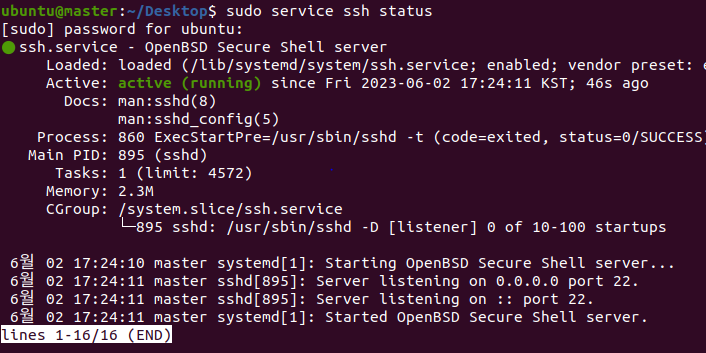

In [ ]:
# 만약 ssh서버가 활성화 되어있지 않다면 다음 명령어를 통해 서버 실행
sudo service ssh start

In [ ]:
# 각 가상머신의 IP주소 확인
# master, worker01, worker02, worker03 각각 확인해준다
# 간단하게 ip a를 입력해도 된다
ip addr show

* SSH 연결은 크게 두가지 방법이 존재
    1. Hadoop환경설정 파일을 정의하여 IP주소와 포트 번호로 접속
    2. 각 머신의 호스트명 사용
* 1의 경우에는 문제가 없으나 2의 경우 /etc/hosts파일에 각 호스트(가상 머신)가 어떤 ip주소를 가지고 있는지 정의해야 한다.
    - 2의 경우, /etc/hosts파일에서 IP를 찾지 못할 경우 정상적인 하둡 데몬 실행이 불가능

In [ ]:
# /etc/hosts 파일 열기
sudo vi /etc/hosts

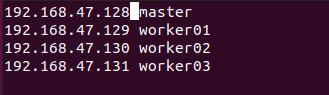

* 위 과정을 worker01, worker02, worker03에서도 명령어를 통해 각각 IP주소를 저장해주면 된다.

## SSH 설정

* 그냥 ssh명령어를 사용하여 SSH를 사용할 경우 접속할 때마다 대상 머신의 비밀번호를 입력해야 한다. <br>
-> 공개키를 다른 서버에 복사하여 이를 해결
* 공개키는 보통 /home/{USER}/.ssh 디렉토리에 생성됨
* .ssh 디렉토리가 존재하지 않는다면 직접 생성해도 되지만, SSH 키 쌍을 생성하면 자동으로 디렉토리가 생성된다.

In [ ]:
# 입력란은 선택사항으로, Enter를 눌러 진행하면 된다
ssh-keygen -t tsa

* 위의 결과를 통해 키 쌍 생성으로 /home/{USER}/.ssh 디렉토리 내 id_rsa(비공개 키), id_rsa.pub(공개 키)파일이 생성되었으면 ssh-copy-id를 사용하여 공개키를 모든 서버(master를 포함하여)들에 복사한다.<br>
(공개키는 접속 대상 서버의 /home/{USER}/.ssh/authorized_keys에 복사됨)

In [ ]:
ssh-copy-id {username}@{hostname}

# worker01의 경우(사용자마다 username이 다르므로 유의할 것)
ssh-copy-id worker01@worker01

# worker01의 경우
ssh-copy-id worker02@worker02

# hostname 대신 ip주소를 입력해도 된다

* 명령어 실행 후 'yes'와 접속하고자 하는 서버의 해당 사용자 계정 

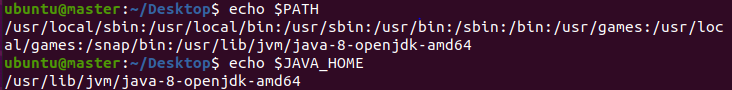

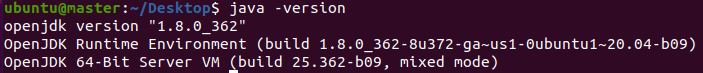

#### worker01의 결과

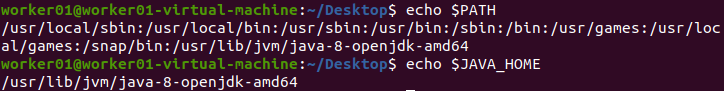

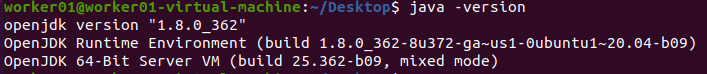

#### worker02의 결과

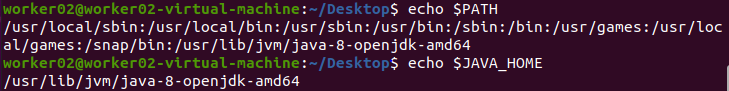

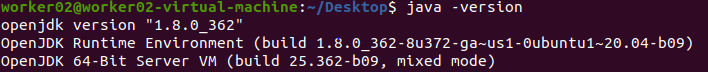

#### worker03의 결과

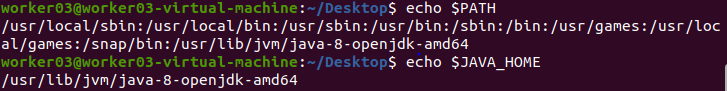

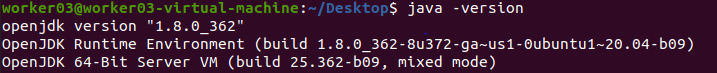

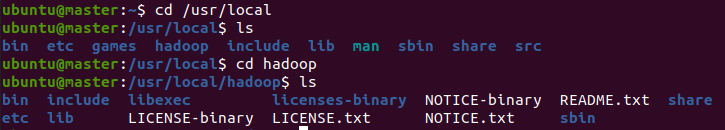